In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#from local.lib import histos2d as h2
from progressbar import progressbar as pbar
from progressbar import ProgressBar
import seaborn as sns
import pandas as pd
from local.lib import histos2d as h2

%matplotlib inline

In [236]:
class HTest2D:
    
    def __init__(self):
        from scipy.integrate import dblquad
        x0_range, x1_range = self.get_domain()
        r = dblquad(self.updf, *x0_range, lambda x: x1_range[0], lambda x: x1_range[1])
        assert r[1]<1e-5, "integration for normalization constant did not converge"
        self.Z = r[0]
    def get_domain(self):
        pass
    
    def updf(self, x0, x1):
        # unnormalized pdf
        pass
    
    def pdf(self, x0, x1):
        return self.updf(x0,x1)/self.Z
    
    def likelihood(self, x):
        return np.sum(np.log(self.pdf(x[:,0], x[:,1])))
    
    def rvs(self, n, use_pbar=False):
        # importance sampling (I know, it's primitive!!)        
        r = np.r_[[[0,0]]]
        
        if use_pbar:
            p = ProgressBar(max_value=n)
        while len(r)<n:
            s = np.random.random(size=(1000000,2))
            s[:,0] = s[:,0]*(x0r[1]-x0r[0]) + x0r[0]
            s[:,1] = s[:,1]*(x1r[1]-x1r[0]) + x1r[0]
            si = s[self.pdf(s[:,0], s[:,1])>np.random.random(len(s))]
            r = np.concatenate((r, si))
            if use_pbar:
                p.update(np.min([len(r),n]))
        r = r[1:n+1]   
        return r
    
    def plot_pdf(self):
        x0_range, x1_range = self.get_domain()
        x0 = np.linspace(*x0_range, 100)
        x1 = np.linspace(*x0_range, 100)
        X0, X1 = np.meshgrid(x0,x1)
        cs = plt.contour(X0, X1, self.pdf(X0, X1), colors="black")
        plt.contourf(X0, X1, self.pdf(X0, X1), cmap="coolwarm")
        plt.colorbar()
        
    def plot_sample(self, x):
        sns.jointplot(data=pd.DataFrame(x, columns=["x0", "x1"]), x="x0", y="x1", alpha=.1)
        
        
class SignalBg2D (HTest2D):
    
    def __init__(self, mu=0, t=0.03, mu_s=80, sigma_s=6):
        self.mu = mu
        self.mu_s = mu_s
        self.sigma_s = sigma_s
        self.t = t
        self.dsignal = stats.norm(loc=mu_s, scale=sigma_s)
        self.dbg = stats.expon(scale=1/t)
        self.ps, self.pb = self.get_sb_probs(mu)
        
        super().__init__()
        
    def get_sb_probs(self, mu):
        """
        scales p_s by mu and then normalizes with the corresponding complementary p_b
        """
        p_s = mu
        p_b = 1.
        z = p_s + p_b
        p_s = p_s/z
        p_b = p_b/z

        return p_s, p_b
    
    def rvs(self, n, use_pbar=False):
        ns = int(n*self.ps) # number of samples for signal
        nb = n-ns           # number of samples for background
        x0 = np.concatenate((self.dsignal.rvs(ns),self.dbg.rvs(nb)))
        x1 = np.concatenate((self.dsignal.rvs(ns),self.dbg.rvs(nb)))
        r = np.r_[[x0,x1]].T
        r = np.random.permutation(r)
        return r    
    
    def get_domain(self):
        return np.r_[[[0,150], [0,200]]]
    
    def updf(self, x0,x1):
        # unnormalized pdf
        f1 =  self.dbg.pdf(x0)*self.pb + self.dsignal.pdf(x0)*self.ps
        f2 =  self.dbg.pdf(x1)*self.pb + self.dsignal.pdf(x1)*self.ps
        
        #f1 =  np.exp(-x0/35)+np.exp( -.5*( (x0-self.mu_s)/5)**2)*self.mu
        #f2 =  np.exp(-x1/35)+np.exp( -.5*( (x1-self.mu_s)/5)**2)*self.mu
        return f1*f2

        # unnormalized pdf
#        f1 =  np.exp(-x0/50)/1.2+np.exp( -.5*( (x0-60)/5)**2)/3
#        f2 =  np.exp(-x1/50)/1.2+np.exp( -.5*( (x1-60)/5)**2)/3
        return f1*f2
    
    
from joblib import Parallel, delayed   
import sys
class mParallel(Parallel):
    """
    substitutes joblib.Parallel with richer verbose progress information
    """
    def _print(self, msg, msg_args):
        if self.verbose > 10:
            fmsg = '[%s]: %s' % (self, msg % msg_args)
            sys.stdout.write('\r ' + fmsg)
            sys.stdout.flush()



In [237]:
x0 = np.concatenate((np.random.random(10), np.random.random(10)))
x1 = np.concatenate((np.random.random(10), np.random.random(10)))
np.r_[[x0,x1]].T.shape

(20, 2)

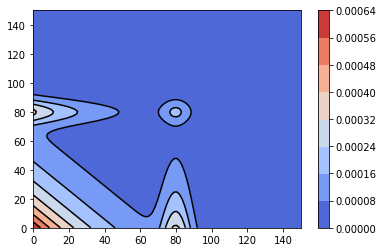

In [238]:
k = SignalBg2D(mu=.2)
k.plot_pdf()

### distribution of a sample

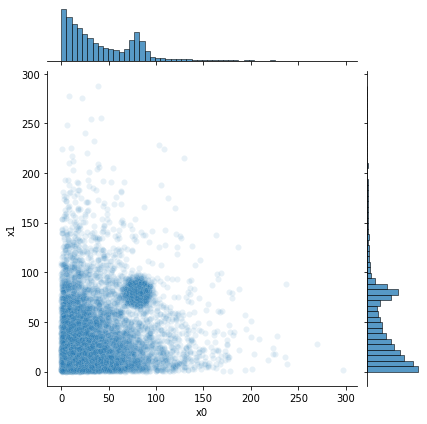

In [239]:
x = k.rvs(10000, use_pbar=True)
k.plot_sample(x)

### compare the 1D model with the marginal distirbution of the 2d model

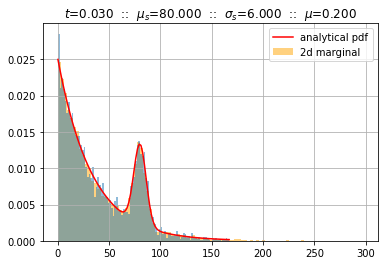

In [240]:
alpha=0.05
t, mu_s, sigma_s, real_mu = 0.03, 80, 6, 0.2
n_events = 5000 # number of events per experiment
H0_1d = h2.MLE_SignalBg(params=[t, mu_s, sigma_s, real_mu])
plt.hist(x[:,0], bins=100, density=True, alpha=.5, color="orange", label="2d marginal");
H0_1d.plot_sample(H0_1d.rvs(n_events), bins=100)


# $H_0$: $\mu=0$

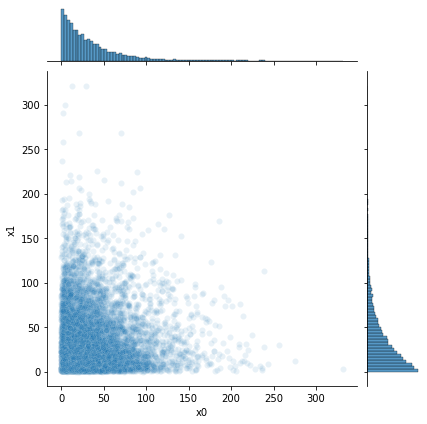

In [258]:
h0 = SignalBg2D(mu=0)
x = h0.rvs(10000, use_pbar=True)
k.plot_sample(x)

In [259]:
lks = [h0.likelihood(k.rvs(10000)) for _ in pbar(range(10000))]

100% (10000 of 10000) |##################| Elapsed Time: 0:00:23 Time:  0:00:23


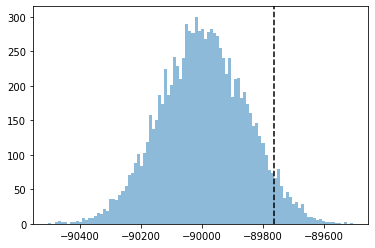

In [261]:
lkhd_limit = np.percentile(lks, 95)
plt.hist(lks, bins=100, alpha=.5);
plt.axvline(lkhd_limit, ls="--", color="black")

In [278]:
test_mus = np.linspace(0,.1,10)
power = []
for test_mu in test_mus:
    h1 = SignalBg2D(mu=test_mu)
    likelihoods = np.r_[[h0.likelihood(h1.rvs(10000)) for _ in pbar(range(1000))]]    
    power.append(np.mean(likelihoods>lkhd_limit))
    

100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1000 of 1000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


In [279]:
power

[0.047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

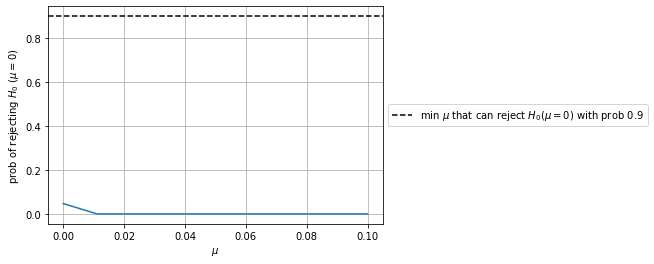

In [280]:
plt.plot(test_mus, power)
plt.grid();
plt.xlabel("$\mu$")
plt.ylabel("prob of rejecting $H_0$ ($\mu=0$)")
plt.axhline(0.9, label="min $\mu$ that can reject $H_0 (\mu=0)$ with prob 0.9", color="black", ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));